<a href="https://colab.research.google.com/github/MunkiPark/Deeplearning-Application/blob/main/NLP_4_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP part 4
WaveNet 2016 from DeepMind https://arxiv.org/abs/1609.03499


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read in all the words
words = open('/content/drive/MyDrive/DeepApp/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


### Building wavenet

In [ ]:
# Near copy paste of the layers we have developed in Part 3
# but FlattenConsecutive added
# and BatchNorm1d is revised for wavened

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True): #fan_in : 입력 dim=이전 layer의 node 수, fan_out : 출력 dim=현재 layer의 node 수
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d: #NLP 3의 batchnorm에서 dim 바꾸는 부분 추가

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop) : 해당 batch에서 계산한 값
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update') : 최종적으로 momentum update로 학습된 값
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: #(B, C)일 때 : flatten된 상태일 때 -> B : batch안 의 sample 개수 / C : sample의 구성 요소 개수
        dim = 0
      elif x.ndim == 3: #(B, T, C)일 때 : 아직 flatten 안된 상태일 때 -> B : batch안 의 sample 개수 / T : sample 1개의 글자 개수 / C : 글자 1개의 embadding 개수
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
      # dim=0 : 각 배치 안의 C들에 대한 평균, 분산
      # dim=(0,1) : 각 배치 안의 stream 안의 C에 대한 평균, 분산 -> sample 안에서의 모든 embadding들의 mean, val
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim): # 아래에서 27(알파벳 개수)*10(각 알파벳마다 할당되는 10개의 값=크기가 10인 벡터)이 들어감
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX] # IX가 [1, 3, 5]라면, self.weight의 1, 3, 5번 행(a,c,e)에 해당하는 벡터들이 반환
    return self.out

    # IX가 스칼라일 때:
    # self.out의 크기: (embedding_dim,) -> list 1개
    # 예: (10,) (벡터 하나)

    # IX가 1D 텐서일 때:
    # self.out의 크기: (len(IX), embedding_dim) -> len(IX)개의 list를 묶은 list
    # 예: (3, 10) (3개의 벡터)

    # IX.shape = (2, 2)라면:
    # self.out의 크기: (2, 2, embedding_dim) -> list 4개를 (2, 2)로 묶은 list
    # 예: (2, 2, 10) (2x2 행렬, 각 요소가 벡터)

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive: # 이 클래스 빼고는 NLP3의 layer들과 같음

  def __init__(self, n):
    self.n = n                                                  # Number of consecutive elements to flatten

  def __call__(self, x):
    B, T, C = x.shape                                           # Get B : batch size, T : sequence length = sample의 글자 개수, and C : channels = embadding
    x = x.view(B, T//self.n, C*self.n)                          # Reshape to combine consecutive elements -> T를 줄이고 그만큼 C를 증가 / 전체 양은 변화X
    if x.shape[1] == 1:
      x = x.squeeze(1)                                          # Remove dimension if sequence length is 1
    self.out = x
    return self.out

  def parameters(self):
    return []                                                   # No parameters to optimize

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors : 각 알파벳들이 가질 10개의 값
n_hidden = 300 # the number of neurons in the hidden layer of the MLP : hidden layer의 node 개수
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
#n_embd = 24 # the dimensionality of the character embedding vectors
#n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd), # vocab_size = 27, n_embd = 10 -> output : (4, 8, 10)
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # FlattenConsecutive(2) : 각 sample 1개의 글자의 개수를 0.5로 줄이고 글자당 embadding의 수를 2배로 증가
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

376197


### Concat two chars

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # a batch of size 4 samples.
print('ix :',ix) # training data개수 아래의 임의의 숫자 4개의 리스트 -> 해당 숫자들 번째의 data를 모아 하나의 batch 생성
Xb, Yb = Xtr[ix], Ytr[ix] #각각 Xtr과 Ytr의 배치 1개
logits = model(Xb) #배치 1개를 model에 넣은 결과 -> 4개의 data에 대한 Y_hat(27개의 알파벳 각각에 대한 확률)
print('logits :',logits.shape)
print(Xb.shape)
logits

ix : tensor([180657,  53319,  68285,  66775])
logits : torch.Size([4, 27])
torch.Size([4, 8])


tensor([[-0.0487,  0.1271,  0.0997,  0.0300, -0.0236, -0.0538, -0.0781, -0.0633,
         -0.0575,  0.0650, -0.1348,  0.0180, -0.0367, -0.0263, -0.1466, -0.0364,
         -0.0567,  0.1165, -0.0574,  0.0200, -0.0367, -0.0047,  0.0048,  0.0985,
          0.0120, -0.0225,  0.1369],
        [-0.0092, -0.0109, -0.1717, -0.0614,  0.0425,  0.0507,  0.0116,  0.0185,
         -0.1246, -0.1152,  0.1288,  0.0548, -0.0064,  0.0236, -0.0650,  0.0383,
         -0.0041, -0.0140,  0.0735, -0.1577,  0.0354, -0.0335,  0.0844, -0.0859,
          0.1930,  0.0433, -0.0958],
        [-0.0246, -0.0653,  0.0178,  0.0042,  0.0694,  0.0060,  0.0266, -0.0004,
          0.1225, -0.0131, -0.0312, -0.0978,  0.0401,  0.0412,  0.0824,  0.0462,
          0.0426, -0.1129,  0.0301,  0.1511,  0.0228, -0.0159, -0.0556, -0.0041,
         -0.0808, -0.0730, -0.0987],
        [ 0.0799, -0.0255,  0.0612,  0.0858, -0.0692, -0.0084,  0.0245,  0.0191,
          0.0901,  0.0571,  0.0048,  0.0432,  0.0261, -0.0165,  0.1103, -0.0681

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))
  #앞 쪽의 4 : batch의 sample 개수
  #중간의 4 : 각 sample이 가지는 stream의 개수(원래는 8개의 글자였으나 flattenConsecutive 거치면서 그냥 stream이 되어버림)
  #뒤쪽의 20 : 각 stream 안에 있는 20개의 embadding값
  #각 글자들을 풀어내면서 마지막에는 embadding들의 list 형태로 출력
  #변경 : [[a1,...,a10],[b1,...,b10],[c1,...c10],...,[h1,...,h10]] * 4 -> [[a1,...,a10,b1,...,b10],[c1,...,c10,d1,...,d10],...,[g1,...,g10,h1,...,h10]] * 4
  #원래는 맨 처음 embadding에서 flatten을 완전히 끝낸 후 linear에 넣음 -> 여기서는 차원을 유지하면서 조금씩 flatten 진행

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 300)
BatchNorm1d : (4, 4, 300)
Tanh : (4, 4, 300)
FlattenConsecutive : (4, 2, 600)
Linear : (4, 2, 300)
BatchNorm1d : (4, 2, 300)
Tanh : (4, 2, 300)
FlattenConsecutive : (4, 600)
Linear : (4, 300)
BatchNorm1d : (4, 300)
Tanh : (4, 300)
Linear : (4, 27)


First, run the following code when we have 'original network' in above code (decomment original and comment hierarchical network)

In [ ]:
a_ = model.layers[0].out.shape  # output of Embedding layer, [batchsize, block_size, n_emb]
a_

torch.Size([4, 8, 10])

In [ ]:
b_ = model.layers[1].out.shape  # output of Flatten layer, [batchsize, block_size//Number of consecutive elements to flatten, n_emb*Number of consecutive elements to flatten]
b_

torch.Size([4, 4, 20])

In [ ]:
c_ = model.layers[2].out#.shape  # output of Linear layer [batchsize, block_size//Number of consecutive elements to flatten, n_hidden] n_hidden is sometimes called n_channel
print(model.layers[2].weight.shape) # 20개가 들어가서 300개가 나옴
c_

torch.Size([4, 4, 300])


tensor([[[-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775]],

        [[-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-2.4211,  1.1148, -1.1410,  ..., -1.1537, -1.7525, -0.9856],
         [-0.8970,  0.0185, -0.8479,  ...,  0.5230, -0.3436,  3.8189],
         [-0.6375, -0.1351, -1.0036,  ...,  0.0399, -0.4199,  1.1216]],

        [[-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-0.3522, -1.3902, -0.3368,  ..., -0.3427, -1.1694, -1.9676]],

        [[-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],
         [-1.8123,  0.5623,  1.3253,  ..., -0.3096, -1.4505, -2.7775],


In [ ]:
# original network:
# inside the Linear layer is
(torch.randn(4,80) @ torch.randn(80,300) + torch.randn(300)).shape

torch.Size([4, 300])

In [ ]:
# hierarchical network:
# inside the Linear layer is
print((torch.randn(b_) @ torch.randn(n_embd * 2, n_hidden) + torch.randn(c_[-1])).shape)
(torch.randn(4,4,48) @ torch.randn(48,128) + torch.randn(128)).shape

TypeError: randn(): argument 'size' (position 1) must be tuple of ints, but found element of type Tensor at pos 0

In [ ]:
# (1 2)(3 4)(5 6)(7 8)

In [ ]:
list(range(10))[1::2] # 1부터 2씩 더해가면서 indexing

[1, 3, 5, 7, 9]

In [ ]:
e = torch.randn(4,8,10) # we want (4,4,20) such that 2 consecutive char (2*10 emb) becomes one input vector of size 20
# [[10],[10],[10],[10],[10],[10],[10],[10]] -> [([10],[10]), ([10],[10]), ([10],[10]), ([10],[10])]
explicit = torch.cat([e[:,::2,:], e[:,1::2,:]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [ ]:
e.view(4,4,20) == explicit # 제대로 dim이 바뀌었는지 확인

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [T

### See how model() is implemented


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)    # Now, we no longer have model related code in the training loop other than model()
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2965
  10000/ 200000: 2.4065
  20000/ 200000: 1.9990
  30000/ 200000: 2.2653
  40000/ 200000: 2.1032
  50000/ 200000: 2.2364
  60000/ 200000: 1.7450
  70000/ 200000: 1.7769
  80000/ 200000: 2.3657
  90000/ 200000: 2.1347
 100000/ 200000: 1.9779
 110000/ 200000: 1.9091
 120000/ 200000: 1.9991
 130000/ 200000: 1.9061
 140000/ 200000: 2.2201
 150000/ 200000: 1.8199
 160000/ 200000: 1.9357
 170000/ 200000: 1.4204
 180000/ 200000: 1.4681
 190000/ 200000: 1.7221


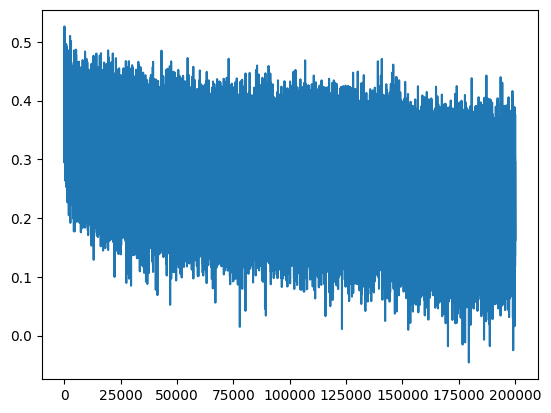

In [ ]:
plt.plot(lossi)
plt.show()

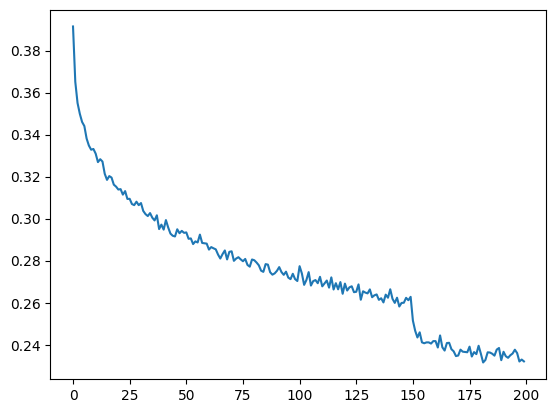

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # Plot the average loss per 1000 steps
plt.show()

In [ ]:
# put layers into eval mode (needed for batchnorm especially) see what happend at the above code
for layer in model.layers:
  layer.training = False # 위의 batchnorm1d에서 batch mean과 learning mean 중 learning mean을 사용하게 됨

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6968271732330322
val 1.9969829320907593


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

alexxa.
gabriee.
senakh.
darian.
harmonie.
samariona.
mycelina.
tiarra.
breone.
wrynton.
devaesha.
wylen.
deniely.
armaya.
zarah.
darleena.
xinobal.
averiko.
everon.
maisen.


### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space